In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from geopy import distance
from geopy.distance import vincenty

pd.set_option('max_column', 100000)
pd.set_option('max_rows', 100000)
pd.set_option('max_colwidth', 100000)
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('/content/drive/MyDrive/fr data/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/fr data/Test.csv')
ss = pd.read_csv('/content/drive/MyDrive/fr data/SampleSubmission.csv')

In [4]:
len_train = len(train)
data = pd.concat([train, test]).reset_index(drop=True)

# Feature Engineering

Groupby and aggregate

In [5]:
pop = data.groupby('population').mean()
pop.drop('target', 1, inplace = True)
cols = []
for i in pop.columns:
    if i != 'population':
        pop[i+'_population_mean_all'] = pop[i]
        pop.drop(i, 1, inplace = True)
        cols.append(i+'_population_mean_all')

data = pd.merge(data, pop, on='population', how = 'left')
for col in cols: data[col+'_freq'] = data[col].map(data[col].value_counts().to_dict())/len(data)

In [6]:
data['std_country_pop'] = data.groupby('country')['population'].transform('std')

In [7]:
a = data.assign(
  atm_cnt = np.where(data['Q1']==1,data.Q1,0),
 Q12_sum = np.where(data['Q12']==1,data.Q12,0),
 Q8_sum = np.where(data['Q8']==1,data.Q8,0),
 Q9_sum = np.where(data['Q9']==1,data.Q9,0),
 Q27_sum = np.where(data['Q27']==1,data.Q27,0),
 Q19_sum = np.where(data['Q19']==1,data.Q19,0)
  ).groupby('country').agg({'atm_cnt':sum, 'Q12_sum':sum, 'Q8_sum':sum, 'Q9_sum':sum, 'Q27_sum':sum, 'Q19_sum':sum})

In [8]:
a.head()

,atm_cnt,Q12_sum,Q8_sum,Q9_sum,Q27_sum,Q19_sum
country,,,,,,
Afghanistan,28,85,98.0,88.0,109.0,83.0
Albania,277,103,230.0,253.0,53.0,100.0
Algeria,239,143,276.0,295.0,74.0,182.0
Argentina,442,67,311.0,369.0,147.0,58.0
Armenia,242,50,199.0,214.0,29.0,140.0


In [9]:
data = data.merge(a, on='country', how='left')

In [10]:
data['mean_age_country'] = data.groupby('country')['age'].transform('mean')
data['max_age_country'] = data.groupby('country')['age'].transform('max')
data['min_age_country'] = data.groupby('country')['age'].transform('min')

data['mean_age_region'] = data.groupby('region')['age'].transform('mean')
data['max_age_region'] = data.groupby('region')['age'].transform('max')
data['min_age_region'] = data.groupby('region')['age'].transform('min')

In [11]:
categoricals_features = ['Q1', 'Q6', 'Q10a', 'Q10b', 'Q11', 'Q12', 'Q13a',
       'Q14', 'Q15', 'Q16', 'Q17a', 'Q17b', 'Q19', 'Q20', 'Q21', 'Q22',
       'Q24', 'Q25', 'Q26', 'owns_mobile']

In [12]:
for col in categoricals_features:
    for agg_type in ['mean','std']:
        new_col_name = col+'_age_'+agg_type
        temp_df =  data.groupby([col])['age'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        data[new_col_name] =  data[col].map(temp_df)

Frequency encode

In [13]:
i_cols2 = ['country','region','population','Q1', 'Q6', 'Q10a', 'Q10b', 'Q11', 'Q12', 'Q13a',
       'Q14', 'Q15', 'Q16', 'Q17a', 'Q17b', 'Q19', 'Q20', 'Q21', 'Q22',
       'Q24', 'Q25', 'Q26', 'owns_mobile']

for col in i_cols2:  
    fq_encode = data[col].value_counts().to_dict()   
    data[col+'_fq_enc'] = data[col].map(fq_encode)

Bin features

In [14]:
def create_bin_features(input_df, features):
    for bin_fe in features:
        print("Binning: ",bin_fe)
        input_df[bin_fe+"_BINS"] = pd.qcut(input_df[bin_fe], 5, labels=False, duplicates='drop')
    
    return input_df

In [15]:
binning_num_features = ['population']

data = create_bin_features(data, binning_num_features)

Binning:  population


In [16]:
def create_bin_features(input_df, features):
    for bin_fe in features:
        print("Binning: ",bin_fe)
        input_df[bin_fe+"_BINS"] = pd.qcut(input_df[bin_fe], 3, labels=False, duplicates='drop')
    
    return input_df

In [17]:
binning_num_features = ['age']

data = create_bin_features(data, binning_num_features)

Binning:  age


In [18]:
data['max_region_pop'] = data.groupby('region')['population'].transform('max')

Label encode

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['region'] = le.fit_transform(data['region'].fillna('missing'))

In [20]:
le = LabelEncoder()
data['country'] = le.fit_transform(data['country'].fillna('missing'))

In [21]:
data['country_target'] = data.groupby('country')['target'].transform('mean')

In [22]:
data.drop("population",axis  = 1,inplace  = True)

# Modelling

Split data

In [24]:
train = data[:len_train]
test = data[len_train:]

In [25]:
X = train.drop(columns=['target', 'ID','Q1', 'Q16', 'std_country_pop', 'min_age_country', 'max_age_region', 'min_age_region', 'Q1_age_std', 'Q6_age_std', 'Q10a_age_mean', 'Q10a_age_std', 'Q14_age_std', 'Q21_age_std', 'Q22_age_mean', 'Q22_age_std', 'Q25_age_mean', 'Q25_age_std', 'Q1_fq_enc', 'Q10b_fq_enc', 'Q13a_fq_enc', 'Q16_fq_enc', 'Q17a_fq_enc', 'Q17b_fq_enc', 'Q21_fq_enc', 'Q22_fq_enc', 'Q26_fq_enc', 'owns_mobile_fq_enc', 'population_BINS', 'max_region_pop'])
y = train['target']
tes = test.drop(columns=['target', 'ID','Q1', 'Q16', 'std_country_pop', 'min_age_country', 'max_age_region', 'min_age_region', 'Q1_age_std', 'Q6_age_std', 'Q10a_age_mean', 'Q10a_age_std', 'Q14_age_std', 'Q21_age_std', 'Q22_age_mean', 'Q22_age_std', 'Q25_age_mean', 'Q25_age_std', 'Q1_fq_enc', 'Q10b_fq_enc', 'Q13a_fq_enc', 'Q16_fq_enc', 'Q17a_fq_enc', 'Q17b_fq_enc', 'Q21_fq_enc', 'Q22_fq_enc', 'Q26_fq_enc', 'owns_mobile_fq_enc', 'population_BINS', 'max_region_pop'])

In [26]:
lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.03,
        'subsample': 1,
        'colsample_bytree': 0.6,
        'reg_alpha': 3,
        'reg_lambda': 4,
        'scale_pos_weight': 1,
        'n_estimators': 5000,
        'silent': -1,
        'verbose': -1,
        'max_depth': -1,
        'seed':2021,
    }

In [27]:
# %%time
testsplit_store=[]
test_store=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit, GroupKFold
from sklearn.metrics import mean_squared_error, f1_score, log_loss, roc_auc_score
from lightgbm import LGBMRegressor, LGBMClassifier

oofs = np.zeros((len(train)))
y_oof = np.zeros((len(train)))
preds = np.zeros((len(test)))


fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=22)
i=1
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    y_oof[test_index] = y_test
    
    lgb = LGBMClassifier(**lgb_params)
    lgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300,verbose=500)
    predict = lgb.predict_proba(X_test)[:,1]
    
    oofs[test_index] = predict
    
    print("err: ", roc_auc_score(y_test,predict))
    testsplit_store.append(roc_auc_score(y_test,predict, average='weighted'))
    pred = lgb.predict_proba(tes)[:,1]
    test_store.append(pred)
    
    preds += pred/10

Training until validation scores don't improve for 300 rounds.
[500]	training's auc: 0.823434	valid_1's auc: 0.806532
[1000]	training's auc: 0.836039	valid_1's auc: 0.807429
[1500]	training's auc: 0.846811	valid_1's auc: 0.807707
Early stopping, best iteration is:
[1286]	training's auc: 0.842393	valid_1's auc: 0.807911
err:  0.8079112003720917
Training until validation scores don't improve for 300 rounds.
[500]	training's auc: 0.8238	valid_1's auc: 0.807058
Early stopping, best iteration is:
[570]	training's auc: 0.825916	valid_1's auc: 0.807236
err:  0.8072361561084564
Training until validation scores don't improve for 300 rounds.
[500]	training's auc: 0.823237	valid_1's auc: 0.810009
[1000]	training's auc: 0.836244	valid_1's auc: 0.810576
[1500]	training's auc: 0.846517	valid_1's auc: 0.810687
Early stopping, best iteration is:
[1400]	training's auc: 0.844522	valid_1's auc: 0.810811
err:  0.810810693648855
Training until validation scores don't improve for 300 rounds.
[500]	training'

In [28]:
np.mean(testsplit_store)

0.8053923649997918

In [29]:
ss['target'] = preds

In [30]:
ss.to_csv('lgb.csv', index=False)

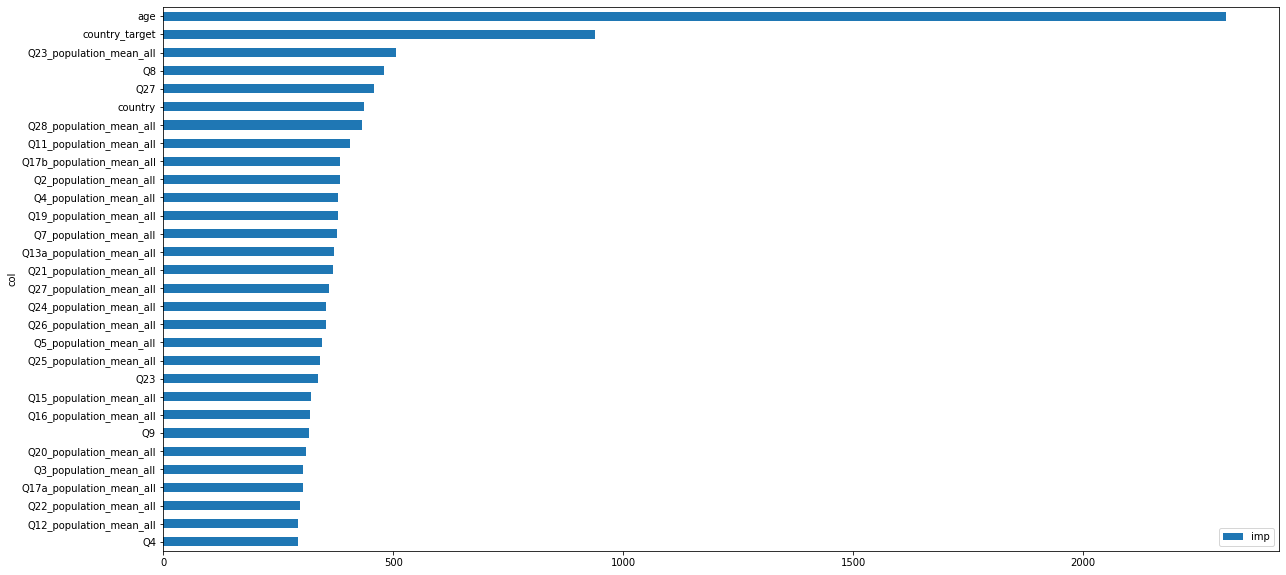

In [31]:
fea_imp = pd.DataFrame({'imp':lgb.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))